<a href="https://colab.research.google.com/github/james-hughes1/wildfire-detection/blob/main/Wildfire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

This is the second project related to the UK heatwave in the summer of 2022. For the GitHub repository of the first project click [here](https://github.com/james-hughes1/UK-Drought-Project). In this Google Colab notebook, I use a [Kaggle dataset](https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data) to train a deep neural network model to detect whether or not there is a wildfire in an image of a natural landscape. My aim is to provide an example of how machine learning can add value to the process of adapting to climate change - in this instance, such an algorithm could be fed real-time imagery from cameras overlooking fields and forests across the UK, and transmit an alert warning to local authorities once a wildfire is detected.

## Load Dataset & Libraries

In [1]:
# Import All Necessary Libraries
import tensorflow as tf
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [2]:
# NOTE: To run this block of code in Colab, ensure that you have the Kaggle API token in the 'content' directory.
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download brsdincer/wildfire-detection-image-data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
wildfire-detection-image-data.zip: Skipping, found more recently modified local copy (use --force to force download)


## Organise Files

In [3]:
# Extract the downloaded .zip file.
local_zip = '/content/wildfire-detection-image-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
# Store the names of all subdirectories of the training data.
source_dir = 'forest_fire'

training_dir = os.path.join(source_dir, 'Training and Validation')
training_dir_fire = os.path.join(training_dir, 'fire')
training_dir_nofire = os.path.join(training_dir, 'nofire')

validation_dir = os.path.join(source_dir, 'Testing')
validation_dir_fire = os.path.join(validation_dir, 'fire')
validation_dir_nofire = os.path.join(validation_dir, 'nofire')

# Display the structure of directories in the training data.
for rootdir, dirs, _ in os.walk(source_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

forest_fire/Training and Validation
forest_fire/Testing
forest_fire/Training and Validation/fire
forest_fire/Training and Validation/nofire
forest_fire/Testing/fire
forest_fire/Testing/nofire


## Exploring the Data

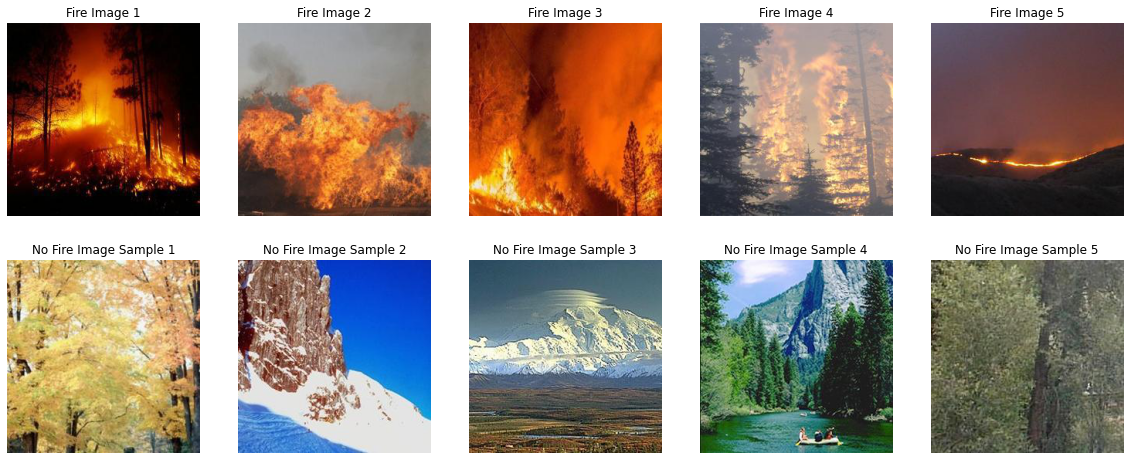

In [5]:
# Sample 5 wildfire and 5 non-wildfire images
photo_dirs = random.sample(os.listdir(training_dir_fire),5) + random.sample(os.listdir(training_dir_nofire),5)
plt.figure(figsize=(20,8))
for i, dir in enumerate(photo_dirs):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  if i < 5:
    plt.title('Fire Image '+str(i+1))
    plt.imshow(mpimg.imread(os.path.join(training_dir_fire, dir)))
  else:
    plt.title('No Fire Image Sample '+str(i-4))
    plt.imshow(mpimg.imread(os.path.join(training_dir_nofire, dir)))

Inspecting some samples of the images in the dataset, we can see that we have a wide variety of images depicting wildfires, and then 'no fire' images depicting of various natural landscapes. Perhaps the biggest drawback of this dataset is that there are clearly quite a few images which do not represent the UK landscape very well, especially the numerous images of snowy mountains.

##Data Engineering (Image Augmentation)

Implementing augmentation with the image generators is a way to prevent overfitting, especially with our limited dataset. I have tried to only include augmentations which would transform the training images into 'simulated' images that could have been taken from an upright camera recording the natural landscape.

In [6]:
# Build training generator with image augmentation.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range = (0.5,1.0),
                                   fill_mode = 'reflect')

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

# Build validation generator without augmentation.
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=20,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 1832 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


## Baseline Model


Given the samples of the images above, the below model seemed to provide a suitable baseline. In particular, it addresses the immediate concern that we could just classify an image as a wildfire - or not - purely based on the average pixel colour of the image, in particular the average amount of 'red' in the pixel values. If the more sophisticated deep learning approaches cannot outperform this then the computational resources required to build them cannot be justified.

In [7]:
# Compile model.
model_base = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(input_shape=(150,150,3)),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model_base.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Train model.
history_base = model_base.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
92/92 [==============================] - 20s 208ms/step - loss: 0.6870 - accuracy: 0.5147 - val_loss: 0.7550 - val_accuracy: 0.3088
Epoch 2/20
92/92 [==============================] - 13s 139ms/step - loss: 0.6795 - accuracy: 0.5426 - val_loss: 0.7329 - val_accuracy: 0.2941
Epoch 3/20
92/92 [==============================] - 13s 137ms/step - loss: 0.6739 - accuracy: 0.5999 - val_loss: 0.7147 - val_accuracy: 0.3088
Epoch 4/20
92/92 [==============================] - 13s 138ms/step - loss: 0.6670 - accuracy: 0.6867 - val_loss: 0.6992 - val_accuracy: 0.4706
Epoch 5/20
92/92 [==============================] - 13s 140ms/step - loss: 0.6628 - accuracy: 0.7145 - val_loss: 0.6893 - val_accuracy: 0.5735
Epoch 6/20
92/92 [==============================] - 14s 151ms/step - loss: 0.6578 - accuracy: 0.7424 - val_loss: 0.6798 - val_accuracy: 0.6912
Epoch 7/20
92/92 [==============================] - 13s 139ms/step - loss: 0.6538 - accuracy: 0.7413 - val_loss: 0.6719 - val_accuracy: 0.7059

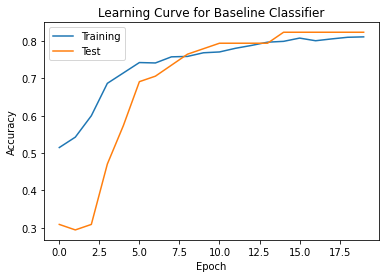

In [8]:
# Plot learning curve.
plt.plot(history_base.history['accuracy'], label='Training')
plt.plot(history_base.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Baseline Classifier')
plt.show()

## Convolutional Neural Networks

### Basic Model

The baseline classifier actually performed very well at around 80% validation accuracy. But there is reason to believe we can achieve better with a more sophisticated approach such as convolutional neural networks. For instance, some of the images of wildfire don't have a lot of red pixels in them at all if they mainly depict a lot of smoke.

Now we evaluate the performance of a convolutional neural network on the classification problem. This CNN has a single convolution and MaxPooling layer, followed by a hidden dense layer with 256 neurons, and then a single-neuron output layer.

In [9]:
# Compile model.
model_cnn1 = tf.keras.Sequential([
    tf.keras.layers.Convolution2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model_cnn1.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [10]:
# Train model.
history_cnn1 = model_cnn1.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
92/92 [==============================] - 15s 145ms/step - loss: 1.4824 - accuracy: 0.8597 - val_loss: 0.4214 - val_accuracy: 0.8529
Epoch 2/20
92/92 [==============================] - 13s 143ms/step - loss: 0.1746 - accuracy: 0.9378 - val_loss: 0.4098 - val_accuracy: 0.8971
Epoch 3/20
92/92 [==============================] - 13s 142ms/step - loss: 0.1543 - accuracy: 0.9449 - val_loss: 0.4547 - val_accuracy: 0.9265
Epoch 4/20
92/92 [==============================] - 13s 141ms/step - loss: 0.1714 - accuracy: 0.9449 - val_loss: 0.5053 - val_accuracy: 0.8824
Epoch 5/20
92/92 [==============================] - 13s 142ms/step - loss: 0.1656 - accuracy: 0.9476 - val_loss: 0.4139 - val_accuracy: 0.9118
Epoch 6/20
92/92 [==============================] - 13s 143ms/step - loss: 0.1679 - accuracy: 0.9427 - val_loss: 0.4771 - val_accuracy: 0.8676
Epoch 7/20
92/92 [==============================] - 13s 142ms/step - loss: 0.1512 - accuracy: 0.9520 - val_loss: 0.4313 - val_accuracy: 0.8235

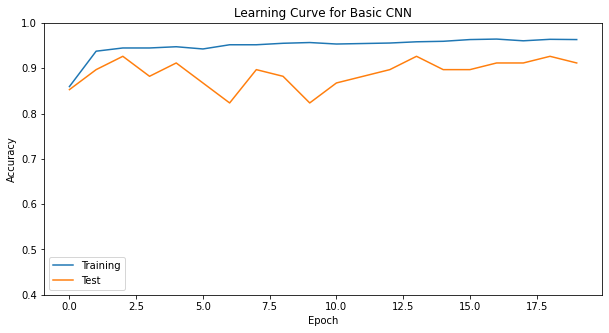

In [11]:
# Plot learning curve.
plt.figure(figsize=(10,5))

plt.plot(history_cnn1.history['accuracy'], label='Training')
plt.plot(history_cnn1.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.4,1.0))
plt.title('Learning Curve for Basic CNN')

plt.show()

### Advanced Model

The next model is also a CNN but its is slightly more complex. This time it has three pairs of convolution and MaxPooling layers. The hidden dense layer has twice as many neurons.

In [12]:
# Compile model.
model_cnn2 = tf.keras.Sequential([
    tf.keras.layers.Convolution2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Convolution2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Convolution2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model_cnn2.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [13]:
# Train model.
history_cnn2 = model_cnn2.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
92/92 [==============================] - 14s 140ms/step - loss: 0.2840 - accuracy: 0.8826 - val_loss: 0.3648 - val_accuracy: 0.8824
Epoch 2/20
92/92 [==============================] - 13s 139ms/step - loss: 0.1883 - accuracy: 0.9372 - val_loss: 0.3185 - val_accuracy: 0.8971
Epoch 3/20
92/92 [==============================] - 13s 138ms/step - loss: 0.1562 - accuracy: 0.9514 - val_loss: 0.5551 - val_accuracy: 0.8529
Epoch 4/20
92/92 [==============================] - 13s 139ms/step - loss: 0.1657 - accuracy: 0.9449 - val_loss: 0.4619 - val_accuracy: 0.9265
Epoch 5/20
92/92 [==============================] - 13s 139ms/step - loss: 0.1210 - accuracy: 0.9623 - val_loss: 0.2154 - val_accuracy: 0.9265
Epoch 6/20
92/92 [==============================] - 13s 140ms/step - loss: 0.1140 - accuracy: 0.9629 - val_loss: 0.2669 - val_accuracy: 0.9265
Epoch 7/20
92/92 [==============================] - 13s 139ms/step - loss: 0.1010 - accuracy: 0.9672 - val_loss: 0.2702 - val_accuracy: 0.8971

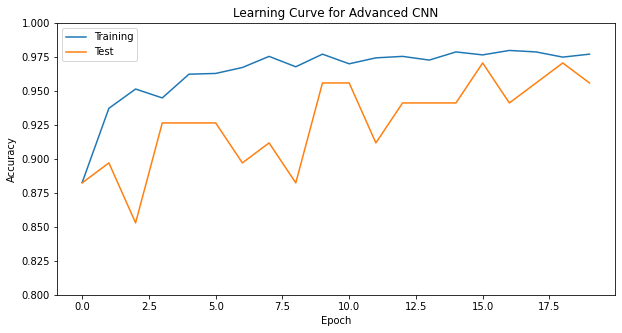

In [14]:
# Plot learning curve.
plt.figure(figsize=(10,5))

plt.plot(history_cnn2.history['accuracy'], label='Training')
plt.plot(history_cnn2.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.8,1.0))
plt.title('Learning Curve for Advanced CNN')

plt.show()

### Adding a Dropout Layer

The final model is the same as the previous one, but it contains a dropout layer before the hidden dense layer.

In [15]:
# Compile model.
model_cnn3 = tf.keras.Sequential([
    tf.keras.layers.Convolution2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Convolution2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Convolution2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_cnn3.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [16]:
# Train model.
history_cnn3 = model_cnn3.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
92/92 [==============================] - 14s 142ms/step - loss: 0.3315 - accuracy: 0.8826 - val_loss: 0.3982 - val_accuracy: 0.8824
Epoch 2/20
92/92 [==============================] - 13s 137ms/step - loss: 0.1728 - accuracy: 0.9421 - val_loss: 0.3184 - val_accuracy: 0.8529
Epoch 3/20
92/92 [==============================] - 13s 138ms/step - loss: 0.1578 - accuracy: 0.9394 - val_loss: 0.2934 - val_accuracy: 0.8824
Epoch 4/20
92/92 [==============================] - 13s 138ms/step - loss: 0.1418 - accuracy: 0.9514 - val_loss: 0.3043 - val_accuracy: 0.9118
Epoch 5/20
92/92 [==============================] - 13s 137ms/step - loss: 0.1383 - accuracy: 0.9541 - val_loss: 0.3713 - val_accuracy: 0.8676
Epoch 6/20
92/92 [==============================] - 13s 136ms/step - loss: 0.1326 - accuracy: 0.9596 - val_loss: 0.3363 - val_accuracy: 0.8824
Epoch 7/20
92/92 [==============================] - 13s 137ms/step - loss: 0.1275 - accuracy: 0.9591 - val_loss: 0.2451 - val_accuracy: 0.8824

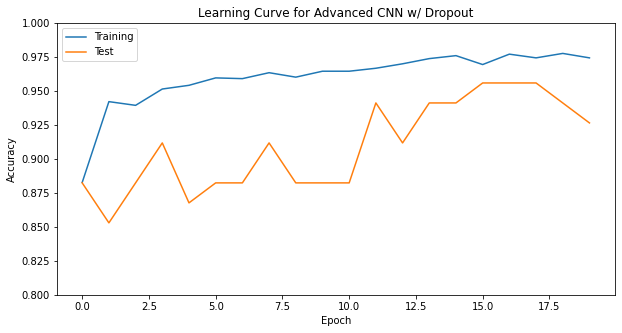

In [17]:
# Plot learning curve.
plt.figure(figsize=(10,5))

plt.plot(history_cnn3.history['accuracy'], label='Training')
plt.plot(history_cnn3.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.8,1.0))
plt.title('Learning Curve for Advanced CNN w/ Dropout')

plt.show()

### Comparing The Models

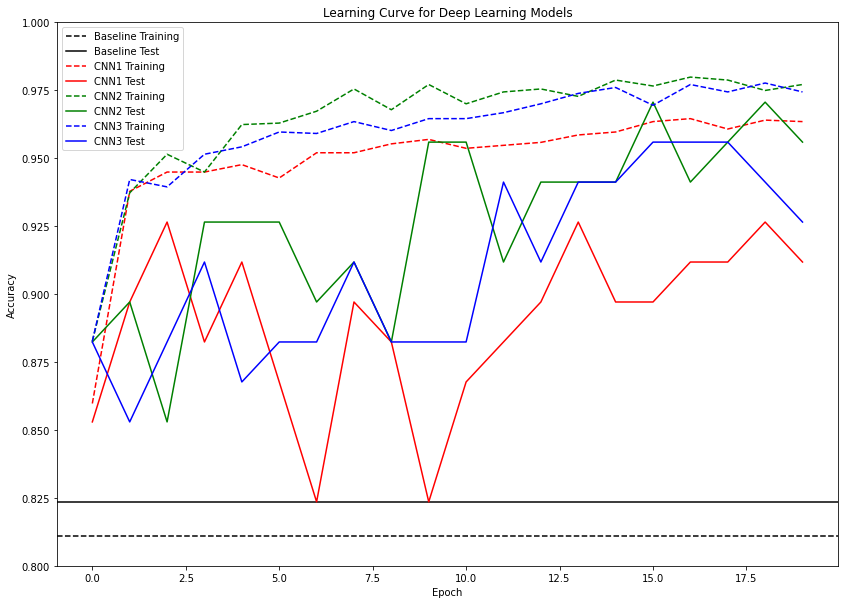

In [18]:
# Plot all three learning curves on the same axes.
plt.figure(figsize=(14,10))

plt.axhline(history_base.history['accuracy'][-1], label='Baseline Training', color='black', linestyle='dashed')
plt.axhline(history_base.history['val_accuracy'][-1], label='Baseline Test', color='black')
plt.plot(history_cnn1.history['accuracy'], label='CNN1 Training', color='red', linestyle='dashed')
plt.plot(history_cnn1.history['val_accuracy'], label='CNN1 Test', color='red')
plt.plot(history_cnn2.history['accuracy'], label='CNN2 Training', color='green', linestyle='dashed')
plt.plot(history_cnn2.history['val_accuracy'], label='CNN2 Test', color='green')
plt.plot(history_cnn3.history['accuracy'], label='CNN3 Training', color='blue', linestyle='dashed')
plt.plot(history_cnn3.history['val_accuracy'], label='CNN3 Test', color='blue')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.8,1.0))
plt.title('Learning Curve for Deep Learning Models')

plt.show()

In [19]:
print("Model:        Average Test Accuracy After 10 Epochs:\n"+"-"*50)
for i, hist in enumerate([history_cnn1, history_cnn2, history_cnn3]):
    print("CNN {:<10}{:.3f}".format(i+1,np.mean(hist.history['val_accuracy'][10:])))

Model:        Average Test Accuracy After 10 Epochs:
--------------------------------------------------
CNN 1         0.903
CNN 2         0.949
CNN 3         0.935


Based on the comparison of learning curves, we can see that increasing the number of convolution layers up to three was worthwhile, but adding the dropout layer added no noticeable gains in accuracy. Therefore it appears that the second CNN model is the most viable.

## Analyse External Images

This can allow us to inspect the way in which the model processes our own custom images of natural landscapes, and consider edge cases. In the GitHub folder I have collected seven varied examples of images to demonstrate the model's behaviour. Many of them are designed to 'catch the model out', but to my surprise the CNN appears to deal with them well. It only seems to have difficulty with the image of the sunset (and sometimes the really smoky wildfire - this is fairly excusable given that it would take extremely little editing to make this appear like a hilly forest with thick clouds in the background). And of course, this is to be expected because the dataset doesn't appear to have any images of non-wildfire landscapes during a sunrise or sunset.

Saving autumn.jpg to autumn.jpg
Saving cloudy forest.jpg to cloudy forest.jpg
Saving field.jpg to field.jpg
Saving red forest house.jpg to red forest house.jpg
Saving smoke.jpg to smoke.jpg
Saving sunset.jpg to sunset.jpg
Saving wildfire flames trees.jpg to wildfire flames trees.jpg


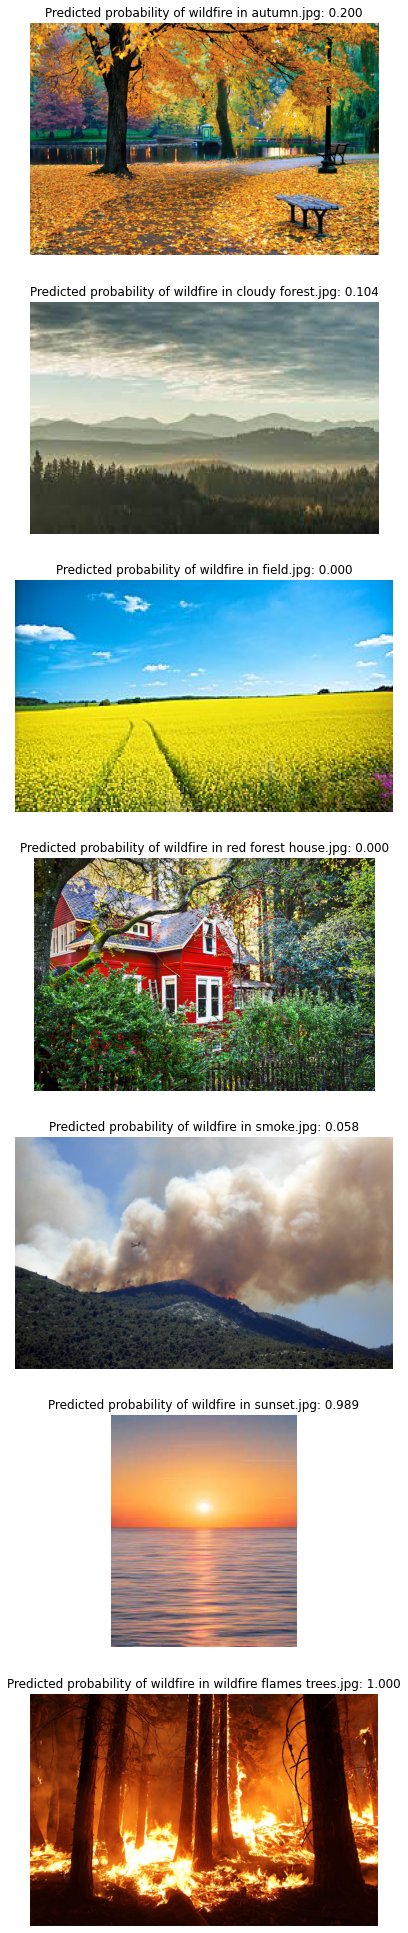

In [20]:
uploaded = files.upload()

n=len(uploaded.keys())
plt.figure(figsize=(10,5*n))

for i, fn in enumerate(uploaded.keys()):

  # Classify image
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))

  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_cnn2.predict(images, batch_size=10)

  # Display image with prediction

  plt.subplot(n,1,i+1)
  plt.axis('off')
  plt.title("Predicted probability of wildfire in {}: {:.3f}".format(fn, 1 - classes[0][0]))
  plt.imshow(mpimg.imread(path))

## Conclusion

This project produced some slightly surprising results. In particular, at first glance it looked as though the classification problem could be approached with a very simple heuristic relating to the average pixel colour values of the image in question. However, by adopting a thorough investigative approach, we gathered evidence to show that this was not the case. While the baseline model which implemented this heuristic was fairly successful, it's performance was much worse than the more advanced CNN models that we implemented. We found that adding convolutional layers further increased the accuracy of the model, but adding a dropout layer did not. In this way, the systematic machine learning approach that we took actually provided us with further insights into the problem, refuting the hypothesis which seemed 'obvious' at first.

The last section allowed us to see the model in action, particularly with our own edge cases. We saw that while the model generalised fairly successfully, it struggled with the image of the sunset. While this failure might seem small, in the context of our objective - producing a model that could be connected to a real-time camera feed - this would potentially produce a false alarm every single day in the morning and evening.

Therefore while we have shown the power of deep learning models to solve object detection problems (in this case a wildfire), the specific model we produced probably would not be suitable for such a context. In order to improve our model, it is clear that we need a larger dataset which contains images more relevant to the specific context, and which cover all times of the day in both the wildfire and non-wildfire classes.

This project was a good opportunity for me to learn how to deal with image data; I used the kaggle API to source the data from the web, and then I had to extract the files from the .zip download, and organise the resulting directories. It was also a chance to practice implementing convolutional neural networks in Colab, which is something I have recently been learning about over the summer. Given the evaluation of the final model, this project is good motivation for me to learn more about web scraping - with better skills in this area I would be able to source a dataset more like the one described above, and produce a better algorithm.

If you have any questions regarding the data I used, or any suggestions as to how I could improve the project please contact me, I would be delighted to hear your thoughts.